Para hacer que el c√≥digo sea m√°s entendible trabajamos todo con funciones, no con codigo suelto.

In [ ]:
  import gdown
  !pip install -q gdown
  import pandas as pd
  from datetime import datetime
  import matplotlib.pyplot as plt
  import seaborn as sns

In [ ]:
def importar_datos(id_drive): #Le paso el id del archivo drive y me retorna el dataframe.
  !gdown --id {id_drive} --output metro_dataset.csv
  data = pd.read_csv("metro_dataset.csv")
  return data

df=importar_datos("1URc9Dfteig1ZlH36xdJ1dE_twfZyoQAq")
df.head()

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1URc9Dfteig1ZlH36xdJ1dE_twfZyoQAq
From (redirected): https://drive.google.com/uc?id=1URc9Dfteig1ZlH36xdJ1dE_twfZyoQAq&confirm=t&uuid=eb8e1d53-2ab8-4032-9e56-b359ac114854
To: /content/metro_dataset.csv
100% 218M/218M [00:03<00:00, 63.4MB/s]


Unnamed: 0            timestamp    TP2    TP3     H1  DV_pressure  \
0           0  2020-02-01 00:00:00 -0.012  9.358  9.340       -0.024   
1          10  2020-02-01 00:00:10 -0.014  9.348  9.332       -0.022   
2          20  2020-02-01 00:00:19 -0.012  9.338  9.322       -0.022   
3          30  2020-02-01 00:00:29 -0.012  9.328  9.312       -0.022   
4          40  2020-02-01 00:00:39 -0.012  9.318  9.302       -0.022   

   Reservoirs  Oil_temperature  Motor_current  COMP  DV_eletric  Towers  MPG  \
0       9.358           53.600         0.0400   1.0         0.0     1.0  1.0   
1       9.348           53.675         0.0400   1.0         0.0     1.0  1.0   
2       9.338           53.600         0.0425   1.0         0.0     1.0  1.0   
3       9.328           53.425         0.0400   1.0         0.0     1.0  1.0   
4       9.318           53.475         0.0400   1.0         0.0     1.0  1.0   

   LPS  Pressure_switch  Oil_level  Caudal_impulses  
0  0.0              1.0        1.0              1.0  
1  0.0              1.0        1.0              1.0  
2  0.0              1.0        1.0              1.0  
3  0.0              1.0        1.0              1.0  
4  0.0              1.0        1.0              1.0

In [ ]:
def estado(fecha): #Funci√≥n  auxiliar para identificar si un instante de tiempo t(x) se encuentra dentro de alg√∫n intervalo donde el compresor reporta fallas.
    #Lista de per√≠odos de fallas (reportado en la descripci√≥n del dataset).
    fallas = [
        (datetime(2020, 4, 18, 0, 0), datetime(2020, 4, 18, 23, 59)),
        (datetime(2020, 5, 29, 23, 30), datetime(2020, 5, 30, 6, 0)),
        (datetime(2020, 6, 5, 10, 0), datetime(2020, 6, 7, 14, 30)),
        (datetime(2020, 7, 15, 14, 30), datetime(2020, 7, 15, 19, 0))
    ]

    #Verificamos si la fecha est√° dentro de alg√∫n per√≠odo
    for inicio, fin in fallas:
      if inicio <= fecha <= fin:
            return 1
    return 0
    #Retorna 1 si se encuentra en un lapso de falla y 0 si est√° funcionando normalmente.


In [ ]:
def estandarizar(dtfr): #Formateamos el tipo de dato de fecha en timestamp. Analizamos valores nulos y datos duplicados.
  dtfr["timestamp"]=pd.to_datetime(dtfr["timestamp"])
  nulos=df.isnull().values.any() #Busca si hay alg√∫n valor nulo en el dataset
  duplicados=df.duplicated().any() #Busca si hay filas repetidas.
  if nulos==False:
    print("No hay datos nulos en el dataset.")
  else:
    print("Revisar nulos por columna.")
  if duplicados==False:
    print("No hay filas duplicadas en el dataset.")
  else:
    print("Revisar duplicados.")
  df['estado'] = df['timestamp'].apply(estado) #Aplico la funci√≥n para crear la columna "estado". En caso de que el valor sea 0 no falla, si es 1 el compresor detecta anomal√≠as en ese momento.

estandarizar(df)


No hay datos nulos en el dataset.
No hay filas duplicadas en el dataset.


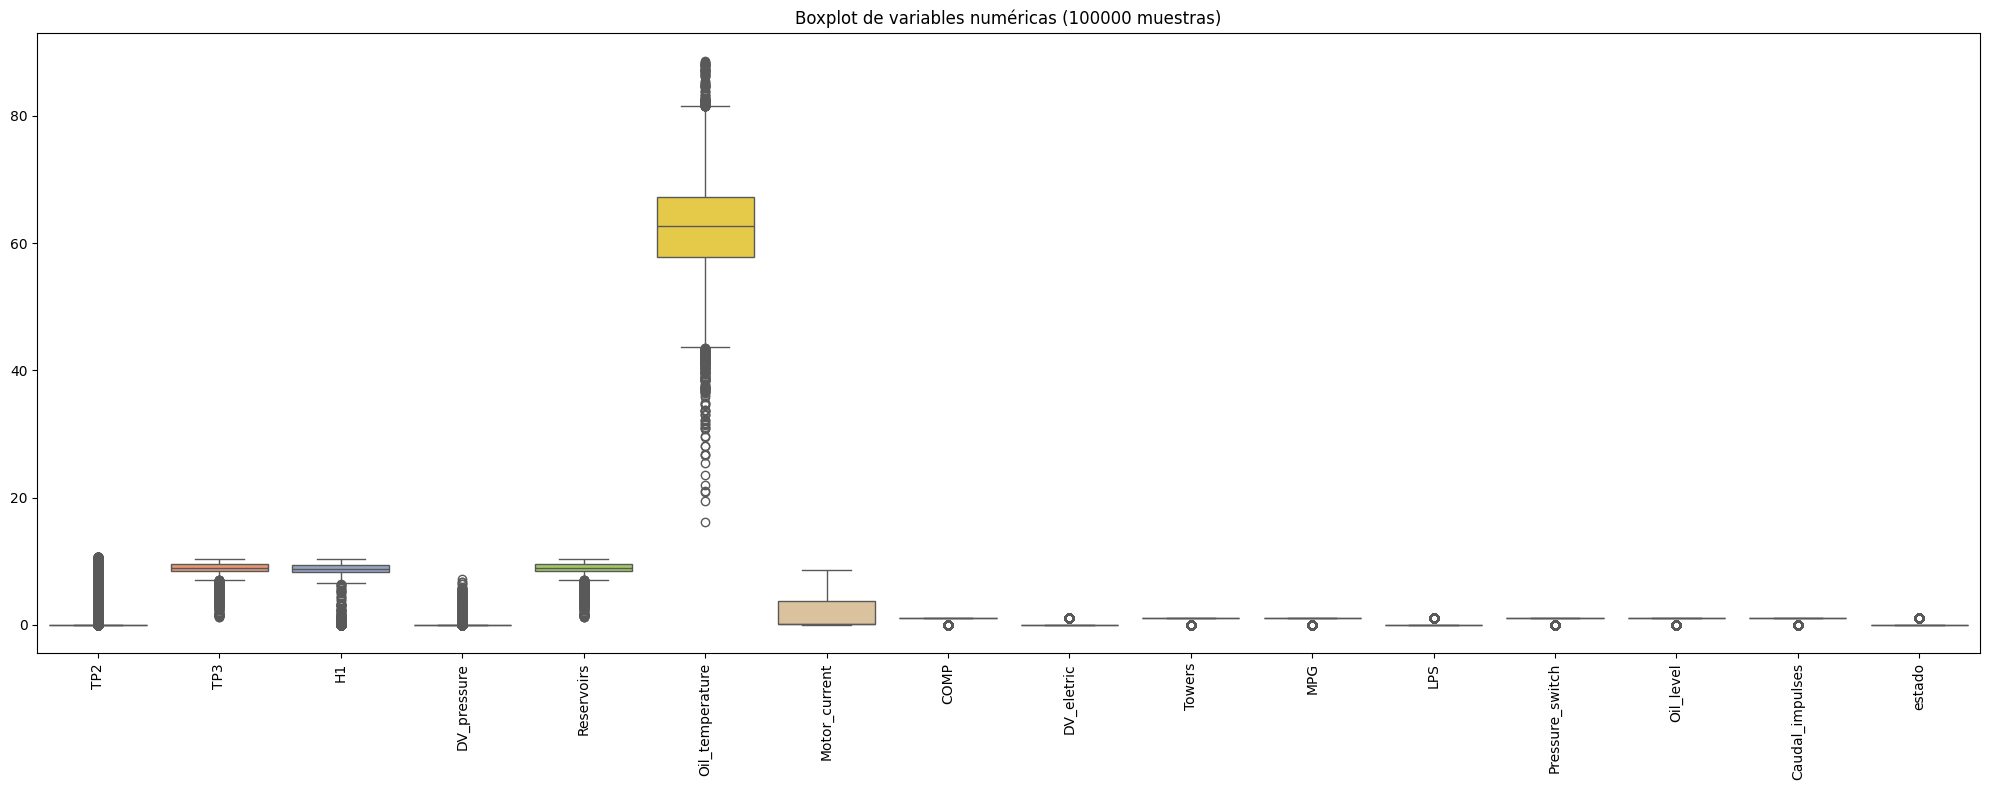

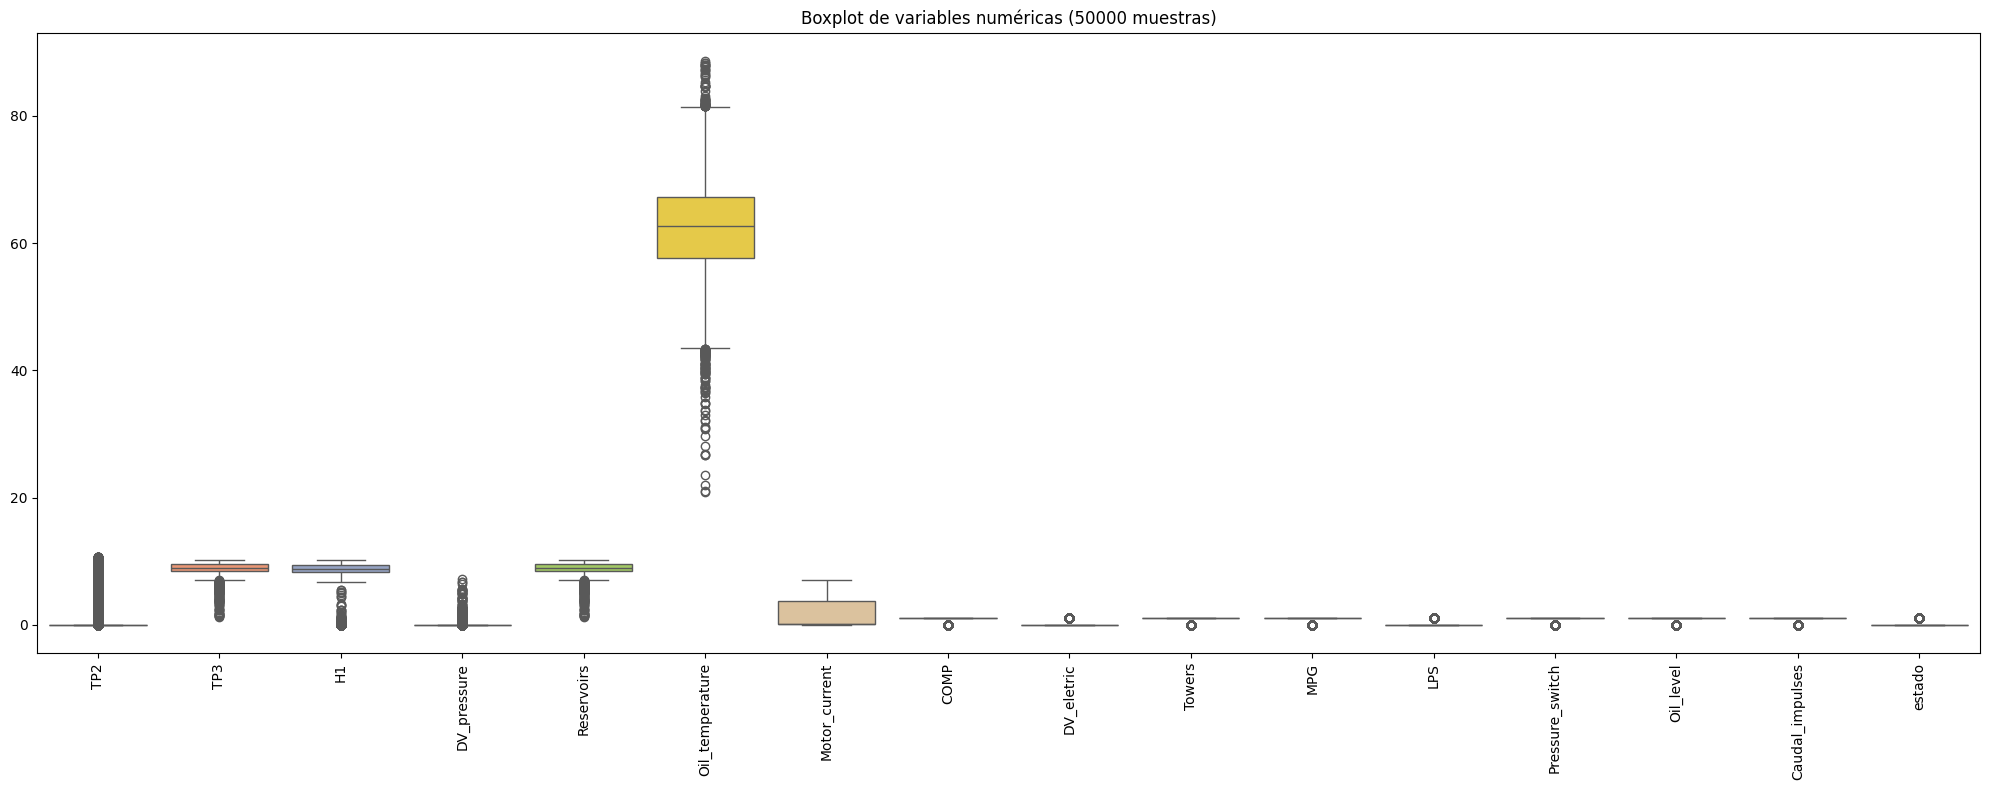

In [ ]:
def boxplot_variables(df, sample_size): #Genera boxplots de todos los valores de sensores para ir viendo a simple vista si hay valores negativos o muchos outliers.
    #Sample_size sirve para elegir la cantidad de muestras para el gr√°fico en caso de querer acelerar la ejecuci√≥n (pasar None para usar todo el DataFrame)

    #Deja solo las columnas de sensores
    columnas_numericas = df.select_dtypes(include=['number']).drop(columns=['Unnamed: 0'], errors='ignore')

    #Aplico muestreo en caso de haberlo pasado
    if sample_size is not None and sample_size < len(columnas_numericas):
        columnas_numericas = columnas_numericas.sample(sample_size, random_state=42)

    #Creo gr√°fico
    plt.figure(figsize=(20, 8))
    sns.boxplot(data=columnas_numericas, palette='Set2')
    plt.xticks(rotation=90)
    plt.title(f'Boxplot de variables num√©ricas ({sample_size} muestras)' if sample_size else 'Boxplot de variables num√©ricas')
    plt.tight_layout()
    plt.show()

boxplot_variables(df, sample_size=100000)  # Con 100k registros
#boxplot_variables(df, sample_size=None)  # Con todos (m√°s lento)
boxplot_variables(df, sample_size=50000)  # Con menos a√∫n


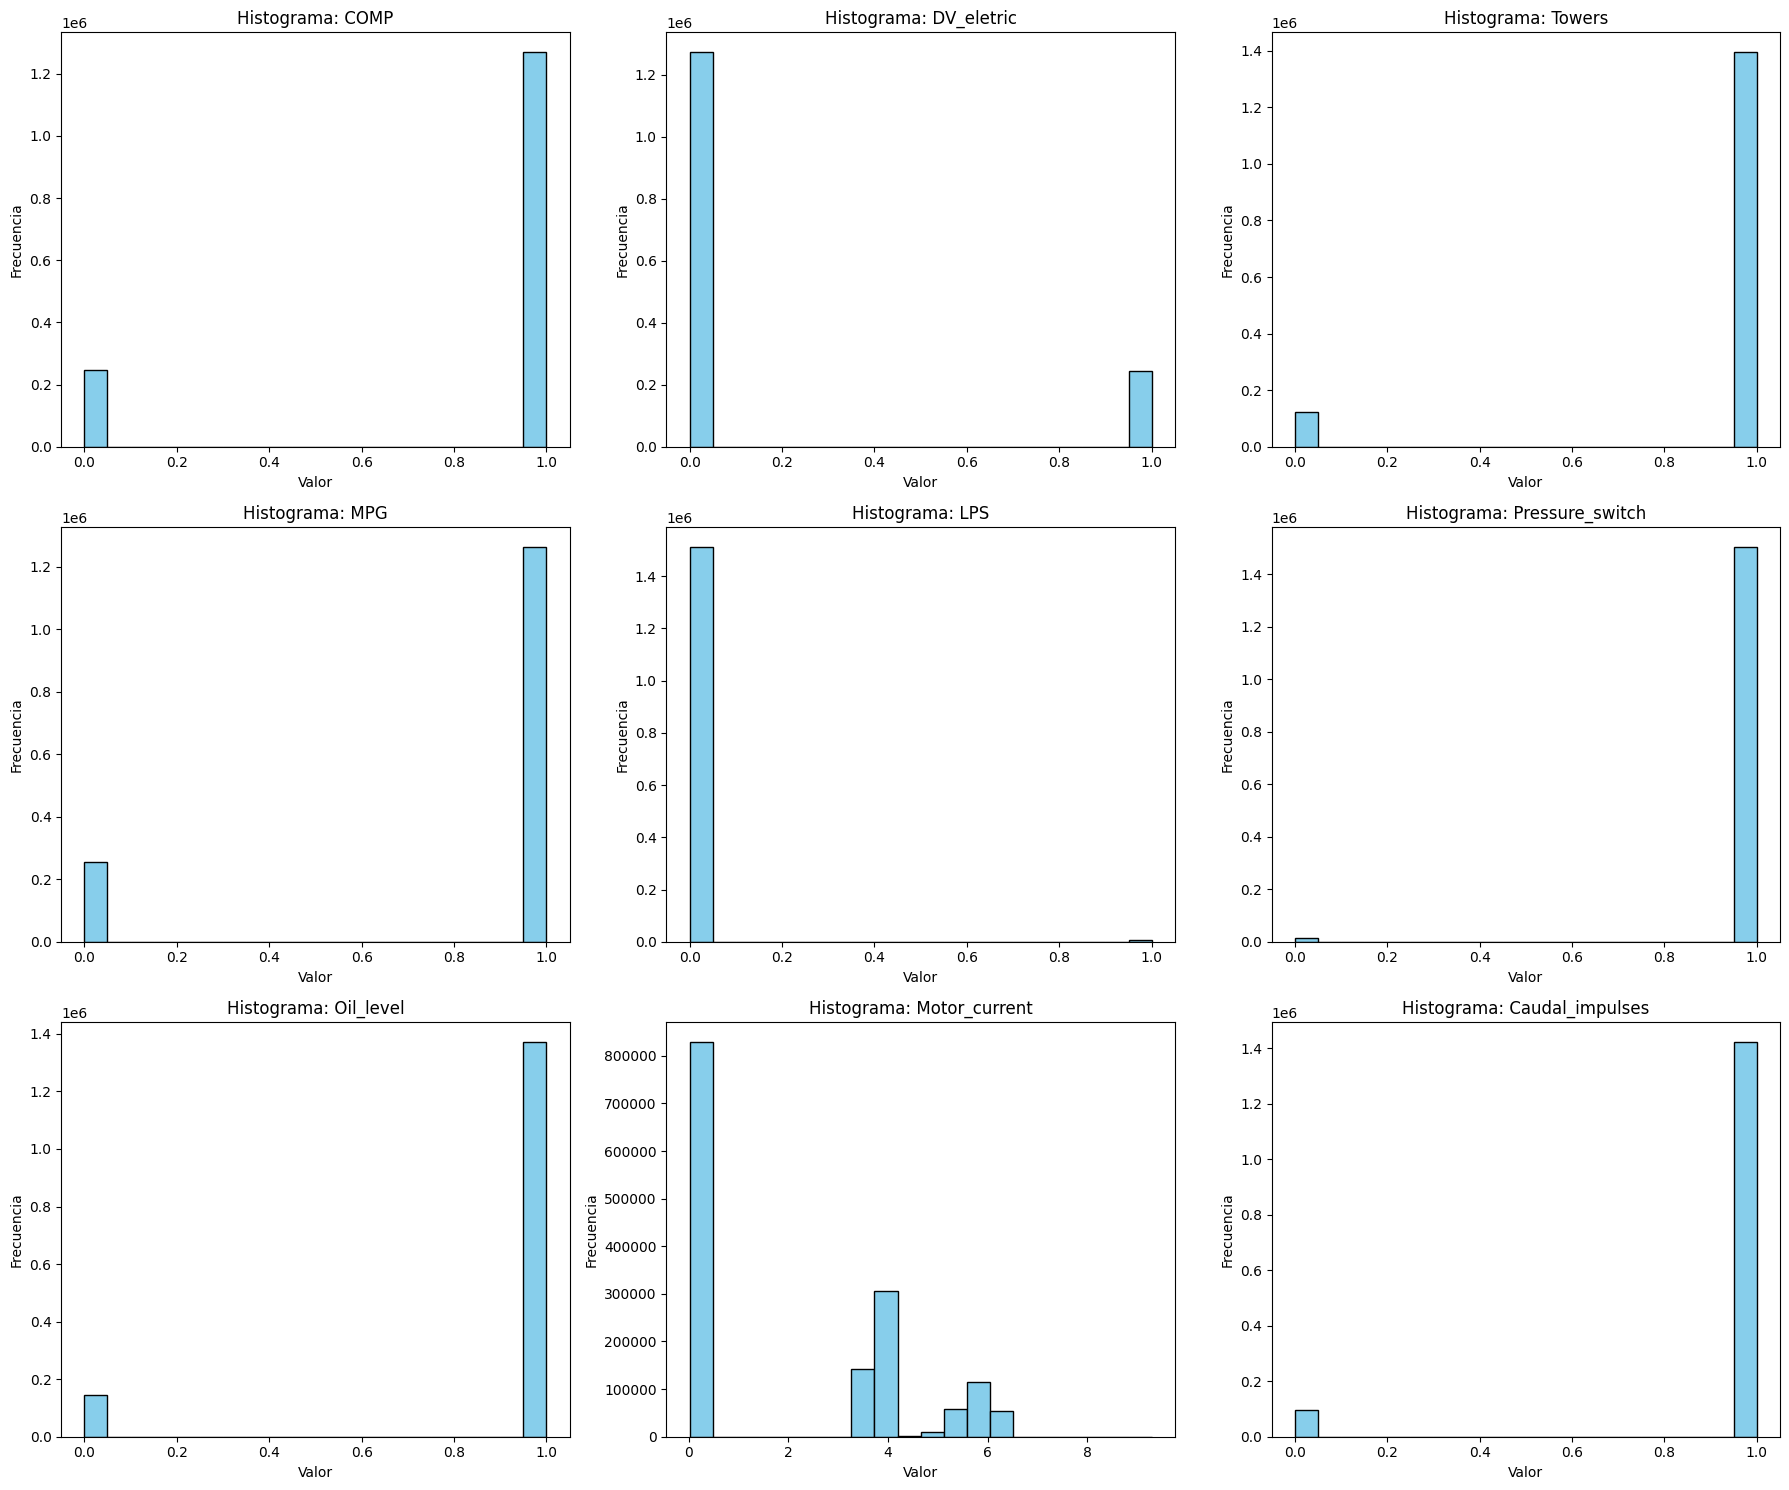

In [ ]:
def histogramas_discretas(df, columnas): #ES UNA FUNCI√ìN "DESCARTE", PARA CHEQUEAR QUE LOS TIPOS DE DATOS SEAN COMO TIENEN QUE SER.
    #LUEGO SE HAR√Å UN AN√ÅLISIS EST√ÅDISTICO DE LAS VARIABLES IMPORTANTES EN UNA ETAPA M√ÅS DETALLADA.
    """
    Genera histogramas para variables discretas o booleanas.

    Par√°metros:
    - df: DAdas
    - columnas: lista de nombres de columnas a graficar
    """

    n = len(columnas)
    filas = (n + 2) // 3  # Calcular cu√°ntas filas de subplots hacen falta

    fig, axes = plt.subplots(nrows=filas, ncols=3, figsize=(18, 5 * filas))
    axes = axes.flatten()

    for i, col in enumerate(columnas):
        axes[i].hist(df[col], bins=20, color='skyblue', edgecolor='black')
        axes[i].set_title(f'Histograma: {col}')
        axes[i].set_xlabel('Valor')
        axes[i].set_ylabel('Frecuencia')

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

columnas_bool_discretas = [
    'COMP', 'DV_eletric', 'Towers', 'MPG', 'LPS',
    'Pressure_switch', 'Oil_level', 'Motor_current', 'Caudal_impulses'
]

histogramas_discretas(df, columnas_bool_discretas)


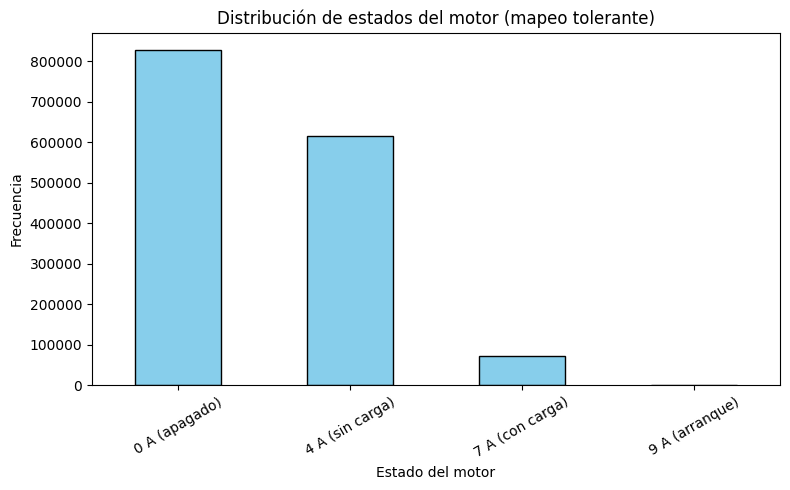

Motor_current
0 A (apagado)      829124
4 A (sin carga)    616160
7 A (con carga)     71657
9 A (arranque)          7
Name: count, dtype: int64

In [ ]:
'''
Motor_current da valores float ya que el sensor no es exacto, muchas veces da 6,9 en vez de 7 por ejemplo. Por eso en el histograma se ven muchas observaciones en el medio cuando en realidad solamente hay 4 tipos de datos para esta variable..
Los valores enteros representan la medida de la corriente de una fase del motor trif√°sico. Cada valor indica
Con esta funci√≥n lo redonde y printeamos como ser√≠a el valor te√≥rico.
'''
def clasificar_motor_current_tolerante(df):
    """
    Clasifica 'Motor_current' en estados operativos usando rangos extendidos.
    Genera un gr√°fico y devuelve el recuento por categor√≠a.
    """
    def clasificar(valor):
        if pd.isna(valor):
            return 'NaN'
        elif valor < 2:
            return '0 A (apagado)'
        elif valor < 6:
            return '4 A (sin carga)'
        elif valor < 9:
            return '7 A (con carga)'
        elif valor<12:
            return '9 A (arranque)'


    clasificado = df['Motor_current'].apply(clasificar)
    recuento = clasificado.value_counts().sort_index()

    # Gr√°fico
    plt.figure(figsize=(8, 5))
    recuento.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Distribuci√≥n de estados del motor (mapeo tolerante)')
    plt.ylabel('Frecuencia')
    plt.xlabel('Estado del motor')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

    return recuento
clasificar_motor_current_tolerante(df)



El gr√°fico muestras que no hay outliers significativos, en el medio pueden variar datos del sensor seg√∫n la interpretaci√≥n que se le de al mapeo. Es decir a veces el valor no est√° en 0A ni 4A, est√° en 3 o 1, no es t√°n claro como si fuese una diferencia decimal (ej: 0,1 y 0 √≥ 7,3 y 7). Entoneces, para no introducir un sesgo manual por establecer un criterio de redondeo arbitr√°rio, vamos a trabajar con los datos de las variables originales.

Otra cosa a tener en cuenta: Por qu√© hay tan pocos casos de arranque? Al tratarse de motores industriales de mucha potencia es altamente probable que el pico de tensi√≥n que producen, se produzca en un lapso muy corto de tiempo. Hablamos de un tiempo de milisegundos, lo cual implica una frecuencia de muestreo menor a la nuestra (1hz = 1s). Quiz√°s haya muchos casos donde los sensores no toman este valor porque simplemente no lo detectan por culpa de la frecuencia de muestreo.

Correlaci√≥n entre features. El objetivo es Calcular la matriz de correlaci√≥n, identificar multicolinealidad y variables explicativas. Marcar variables candidatas a eliminar y seleccionar variables de mayor importancia.



# CORRELACION
    

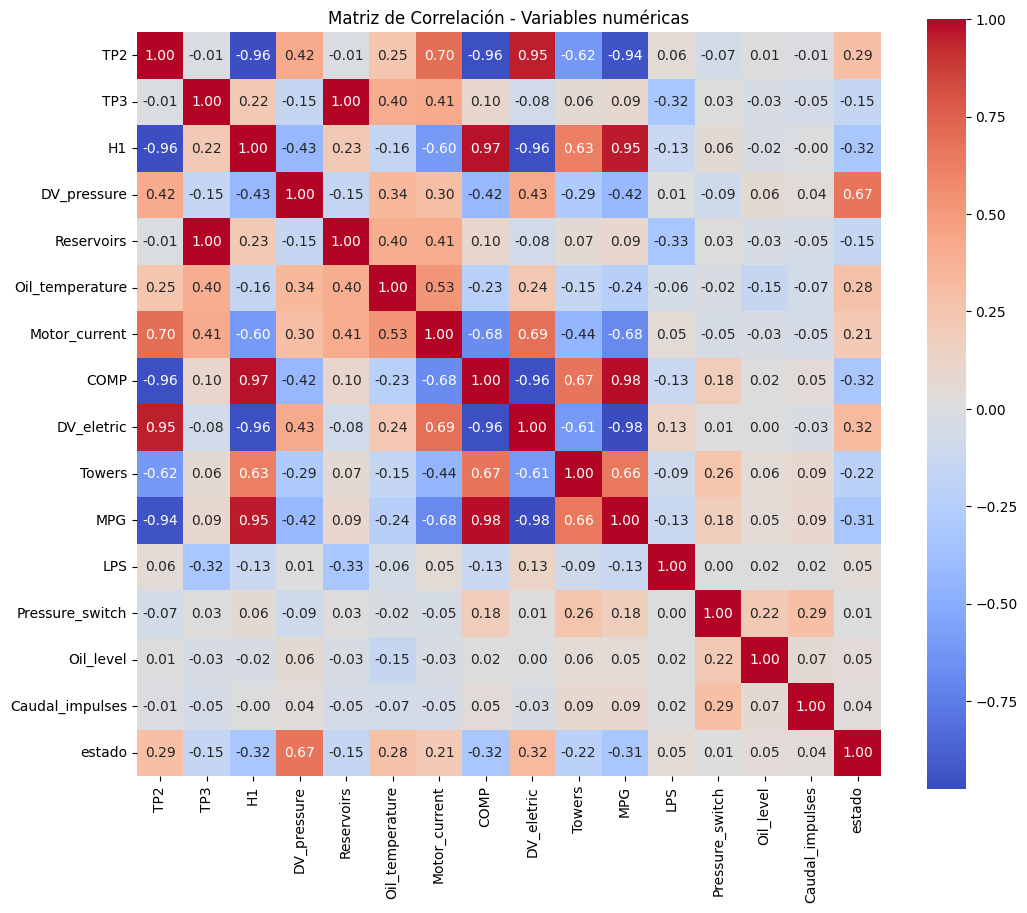

In [ ]:
# Correlaci√≥n de Pearson
#La correlaci√≥n de Pearson mide la fuerza y direcci√≥n de la relaci√≥n lineal entre dos variables num√©ricas
df = df.drop(columns=['Unnamed: 0'])
correlacion = df.corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Matriz de Correlaci√≥n - Variables num√©ricas")
plt.show()


In [ ]:
df.head()

timestamp    TP2    TP3     H1  DV_pressure  Reservoirs  \
0 2020-02-01 00:00:00 -0.012  9.358  9.340       -0.024       9.358   
1 2020-02-01 00:00:10 -0.014  9.348  9.332       -0.022       9.348   
2 2020-02-01 00:00:19 -0.012  9.338  9.322       -0.022       9.338   
3 2020-02-01 00:00:29 -0.012  9.328  9.312       -0.022       9.328   
4 2020-02-01 00:00:39 -0.012  9.318  9.302       -0.022       9.318   

   Oil_temperature  Motor_current  COMP  DV_eletric  Towers  MPG  LPS  \
0           53.600         0.0400   1.0         0.0     1.0  1.0  0.0   
1           53.675         0.0400   1.0         0.0     1.0  1.0  0.0   
2           53.600         0.0425   1.0         0.0     1.0  1.0  0.0   
3           53.425         0.0400   1.0         0.0     1.0  1.0  0.0   
4           53.475         0.0400   1.0         0.0     1.0  1.0  0.0   

   Pressure_switch  Oil_level  Caudal_impulses  estado  
0              1.0        1.0              1.0       0  
1              1.0        1.0              1.0       0  
2              1.0        1.0              1.0       0  
3              1.0        1.0              1.0       0  
4              1.0        1.0              1.0       0

## VARIABLES

## Ventanas

SELECCI√ìN DE CARACTERISTICAS CON RANDOM FOREST


Variables con importancia mayor al 0.05 (5%) suelen ser relevantes.
Variables con m√°s de 0.10 (10%) tienen un impacto significativo en el modelo.
Variables con importancias muy bajas (cerca de 0) deber√≠an ser evaluadas para posibles eliminaciones, ya que podr√≠an ser ruido para el modelo.

**Valores de variables por encima del 0.05:**

DV_pressure = 0.30

Oil_temperature = 0.26

Reservoirs = 0.11

TP3 = 0.10

TP2 = 0.07

H1 = 0.06

no correr random forrest rompe lo q sigue despues

1.   Elemento de lista
2.   Elemento de lista



In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt

def variables_importantes_rf(df, target='estado'):
    """
    Entrena un Random Forest y devuelve la importancia de las variables.
    """
    df_modelo = df.select_dtypes(include='number').drop(columns=['Unnamed: 0'], errors='ignore')
    X = df_modelo.drop(columns=[target])
    y = df_modelo[target]

    modelo = RandomForestClassifier(n_estimators=100, random_state=42)
    modelo.fit(X, y)

    # Obtener la importancia de las variables
    importancias = pd.Series(modelo.feature_importances_, index=X.columns).sort_values(ascending=False)

    # Graficar la importancia de las variables
    plt.figure(figsize=(10, 6))
    importancias.head(15).plot(kind='bar')
    plt.title('Importancia de variables (Random Forest)')
    plt.ylabel('Importancia')
    plt.tight_layout()
    plt.show()

    # Guardar las importancias en una lista
    importancias_lista = importancias.tolist()

    return importancias, importancias_lista
dfrandom=df
# Llamar a la funci√≥n y almacenar tanto el DataFrame como la lista
importancias_rf, importancias_lista = variables_importantes_rf(dfrandom)

# Imprimir la lista de importancias
print(importancias_lista)


KeyboardInterrupt: 

# SUBSAMPLING Y ARMADO DE MODELO PARA POC

El proceso ser√° el siguiente: crear un intervalo de datos previo a la falla de igual tama√±o que la falla. Haciendo eso en 2 fallas vamos a tener los datos para entrenar el modelo para la POC. De manera tal que no tengamos que hacer el subsampling total del dataset pero podamos utilizar una muestra balanceada en ambas clases.


In [ ]:
def subsampling(df, intervalo_falla):
    """
    Realiza un submuestreo de datos igual al tama√±o de la falla, pero usando los datos previos a la falla.
    Recibe un intervalo de falla (inicio, fin) y devuelve un DataFrame con el mismo tama√±o de datos
    antes de la falla.

    Par√°metros:
    - df: DataFrame original con el que se hace el submuestreo.
    - intervalo_falla: Tupla con las fechas de inicio y fin de la falla.

    Retorna:
    - Un DataFrame con los datos previos a la falla con la misma cantidad que los de la falla.
    """
    # Convertir las fechas de inicio y fin a datetime
    inicio, fin = pd.to_datetime(intervalo_falla[0]), pd.to_datetime(intervalo_falla[1])

    # Obtener los datos de la falla
    datos_falla = df[(df["timestamp"] >= inicio) & (df["timestamp"] <= fin)].copy()

    # Determinar cu√°ntos puntos de datos hay en la falla (cu√°ntos registros)
    num_falla = len(datos_falla)

    # Encontrar el √≠ndice de inicio m√°s cercano en el DataFrame
    idx_inicio = df[df["timestamp"] >= inicio].index[0]  # Esto garantiza que obtienes el primer √≠ndice >= inicio

    # Tomar los mismos 'num_falla' puntos antes de la falla
    idx_pre_falla = idx_inicio - num_falla

    # Obtener los datos previos (usando los √≠ndices calculados)
    datos_pre_falla = df.iloc[idx_pre_falla:idx_inicio].copy()

    return datos_pre_falla, datos_falla

# Ejemplo de uso con las fallas proporcionadas
falla1 = ("2020-04-18 00:00:00", "2020-04-18 23:59:00")
datospoc1_pre, datospoc1_falla = subsampling(df, falla1)

falla2 = ("2020-05-29 23:30:00", "2020-05-30 06:00:00")
datospoc2_pre, datospoc2_falla = subsampling(df, falla2)

# Falla 3: ("2020-06-05 10:00:00", "2020-06-07 14:30:00")
falla3 = ("2020-06-05 10:00:00", "2020-06-07 14:30:00")
datospoc3_pre, datospoc3_falla = subsampling(df, falla3)

# Falla 4: ("2020-07-15 14:30:00", "2020-07-15 19:00:00")
falla4 = ("2020-07-15 14:30:00", "2020-07-15 19:00:00")
datospoc4_pre, datospoc4_falla = subsampling(df, falla4)

# Mostrar los resultados
print(f"Datos previos a la falla 1: {len(datospoc1_pre)} puntos")
print(f"Datos durante la falla 1: {len(datospoc1_falla)} puntos")
print(f"Datos previos a la falla 2: {len(datospoc2_pre)} puntos")
print(f"Datos durante la falla 2: {len(datospoc2_falla)} puntos")
df_poc=pd.concat([datospoc1_pre, datospoc1_falla,datospoc2_pre,datospoc2_falla])
print(df_poc)

Datos previos a la falla 1: 8657 puntos
Datos durante la falla 1: 8657 puntos
Datos previos a la falla 2: 2360 puntos
Datos durante la falla 2: 2360 puntos
                 timestamp    TP2    TP3     H1  DV_pressure  Reservoirs  \
553907 2020-04-16 17:30:51 -0.012  9.368  9.356       -0.022       9.368   
553908 2020-04-16 17:31:00 -0.012  9.360  9.348       -0.022       9.358   
553909 2020-04-16 17:31:10 -0.014  9.352  9.338       -0.024       9.350   
553910 2020-04-16 17:31:20 -0.014  9.342  9.330       -0.024       9.340   
553911 2020-04-16 17:31:30 -0.014  9.332  9.322       -0.024       9.332   
...                    ...    ...    ...    ...          ...         ...   
843095 2020-05-30 05:59:15  0.000  9.766  9.750       -0.012       9.774   
843096 2020-05-30 05:59:25  0.000  9.748  9.730       -0.010       9.754   
843097 2020-05-30 05:59:35  0.000  9.728  9.708       -0.010       9.732   
843098 2020-05-30 05:59:44  0.000  9.704  9.686       -0.010       9.708   
843099 2

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Variables que vas a usar para entrenar el modelo
variables_seleccionadas = ["DV_pressure", "Oil_temperature", "Reservoirs", "TP3", "TP2", "H1"]

# Dividir los datos en las variables de entrada (X) y el target (y)
X = df_poc[variables_seleccionadas]  # Ahora seleccionamos solo las variables que elegiste
y = df_poc['estado']  # El target 'estado'

# Dividir los datos en entrenamiento (80%) y prueba (20%) de forma estratificada (manteniendo la proporci√≥n de clases)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Verificar la distribuci√≥n de clases en el conjunto de entrenamiento y prueba
print("Distribuci√≥n en el conjunto de entrenamiento:")
print(y_train.value_counts())
print("\nDistribuci√≥n en el conjunto de prueba:")
print(y_test.value_counts())


Distribuci√≥n en el conjunto de entrenamiento:
estado
1    8814
0    8813
Name: count, dtype: int64

Distribuci√≥n en el conjunto de prueba:
estado
0    2204
1    2203
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Definir el modelo Random Forest
modelo_rf = RandomForestClassifier(random_state=42)

# Definir el espacio de par√°metros a explorar
parametros = {
    'n_estimators': [100, 200, 300, 400, 500],  # N√∫mero de √°rboles
    'max_depth': [None, 10, 20, 30, 40, 50],    # Profundidad m√°xima de los √°rboles
    'min_samples_split': [2, 5, 10, 20],         # N√∫mero m√≠nimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4, 8],            # N√∫mero m√≠nimo de muestras por hoja
    'max_features': ['sqrt', 'log2', None],      # N√∫mero de caracter√≠sticas a considerar para dividir
    'bootstrap': [True, False]                    # Si se usa bootstrap para crear los √°rboles
}


# Realizar RandomizedSearchCV con 100 iteraciones y 5 particiones para cross-validation
random_search = RandomizedSearchCV(estimator=modelo_rf, param_distributions=parametros,
                                   n_iter=100, cv=5, n_jobs=-1, random_state=42, verbose=2)

# Entrenar el modelo con los par√°metros √≥ptimos encontrados por RandomizedSearchCV
# X train y Y test (estado) fueron estimados en la celda anterior
random_search.fit(X_train, y_train)

# Mostrar los mejores par√°metros encontrados
print("Mejores par√°metros:", random_search.best_params_)

# Usar el mejor modelo encontrado para predecir
modelo_rf_optimo = random_search.best_estimator_

# Evaluar el modelo
y_pred = modelo_rf_optimo.predict(X_test)

# Mostrar el reporte de clasificaci√≥n
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Mejores par√°metros: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': True}
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2204
           1       1.00      0.99      1.00      2203

    accuracy                           1.00      4407
   macro avg       1.00      1.00      1.00      4407
weighted avg       1.00      1.00      1.00      4407



In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Definir el modelo Random Forest
modelo_rf = RandomForestClassifier(random_state=42)

# Definir el espacio de par√°metros a explorar
parametros = {
    'n_estimators': [200],  # N√∫mero de √°rboles
    'max_depth': [10],    # Profundidad m√°xima de los √°rboles
    'min_samples_split': [2],         # N√∫mero m√≠nimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4, 8],            # N√∫mero m√≠nimo de muestras por hoja
    'max_features': ['log2'],      # N√∫mero de caracter√≠sticas a considerar para dividir
    'bootstrap': [True]                    # Si se usa bootstrap para crear los √°rboles
}


# Realizar RandomizedSearchCV con 100 iteraciones y 5 particiones para cross-validation
random_search = RandomizedSearchCV(estimator=modelo_rf, param_distributions=parametros,
                                   n_iter=100, cv=5, n_jobs=-1, random_state=42, verbose=2)

# Entrenar el modelo con los par√°metros √≥ptimos encontrados por RandomizedSearchCV
# X train y Y test (estado) fueron estimados en la celda anterior
random_search.fit(X_train, y_train)

# Mostrar los mejores par√°metros encontrados
print("Mejores par√°metros:", random_search.best_params_)

# Usar el mejor modelo encontrado para predecir
modelo_rf_optimo = random_search.best_estimator_

# Evaluar el modelo
y_pred = modelo_rf_optimo.predict(X_test)

# Mostrar el reporte de clasificaci√≥n
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=100. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Mejores par√°metros: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': True}
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2204
           1       1.00      0.99      1.00      2203

    accuracy                           1.00      4407
   macro avg       1.00      1.00      1.00      4407
weighted avg       1.00      1.00      1.00      4407



In [ ]:
import joblib

# Guardar el modelo entrenado
joblib.dump(random_search.best_estimator_, 'modelo_rf_optimo.pkl')

# Cargar el modelo previamente guardado
modelo_rf_optimo = joblib.load('modelo_rf_optimo.pkl')


In [ ]:
def predecir_en_ventanas(df, modelo_rf_optimo, ventana_tama√±o_minutos=20, horizonte_falla_minutos=60):
    """
    Aplica un modelo de Random Forest a datos en ventanas deslizantes.
    Para cada ventana de 20 minutos, predice si habr√° una falla en la siguiente hora.

    Par√°metros:
    - df: DataFrame con los datos hist√≥ricos, con una columna 'timestamp' y otras variables de entrada.
    - modelo_rf_optimo: el modelo Random Forest entrenado.
    - ventana_tama√±o_minutos: tama√±o de la ventana deslizante (en minutos).
    - horizonte_falla_minutos: horizonte de la predicci√≥n (en minutos) para detectar la falla.

    Retorna:
    - DataFrame con las predicciones de cada ventana.
    """

    # Asegurarse de que la columna 'timestamp' est√© en formato datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Lista para guardar las predicciones
    predicciones = []

    # Convertir el tama√±o de la ventana a timedelta
    ventana_tama√±o = pd.Timedelta(minutes=ventana_tama√±o_minutos)
    horizonte_falla = pd.Timedelta(minutes=horizonte_falla_minutos)

    # Deslizar la ventana por todo el DataFrame basado en la columna 'timestamp'
    for i in range(len(df) - 1):  # Recorremos por las filas
        inicio = df['timestamp'].iloc[i]  # Inicio de la ventana (timestamp de la fila actual)
        fin = inicio + ventana_tama√±o  # Fin de la ventana: sumar un 'Timedelta' a 'inicio'

        # Si el fin de la ventana excede el √∫ltimo timestamp disponible, terminamos el bucle
        if fin > df['timestamp'].iloc[-1]:  # Si la ventana excede los datos disponibles, salimos del bucle
            break

        # Extraer la ventana de 20 minutos (de 'inicio' a 'fin')
        ventana = df[(df['timestamp'] >= inicio) & (df['timestamp'] < fin)]

        # Variables de entrada (X) son las columnas de sensores, y el target (y) es 'estado'
        X_ventana = ventana[variables_seleccionadas]  # Aseg√∫rate de tener las variables definidas

        # Predecir la probabilidad de falla en la siguiente hora (horizonte de 60 minutos)
        y_prob = modelo_rf_optimo.predict_proba(X_ventana)

        # Calcular la hora de la falla estimada sumando el horizonte de la predicci√≥n al inicio de la ventana
        hora_falla = inicio + horizonte_falla

        # Almacenar la predicci√≥n para la ventana actual
        predicciones.append({
            'inicio_ventana': ventana['timestamp'].iloc[0],  # Primer timestamp de la ventana
            'probabilidad_falla': y_prob[-1][1],  # Probabilidad de que sea 'falla'
            'falla_prevista': 'falla' if y_prob[-1][1] > 0.7 else 'no falla',
            'hora_falla_predicha': hora_falla  # Hora estimada de la falla (en el futuro)
        })

    # Crear un DataFrame con las predicciones
    predicciones_df = pd.DataFrame(predicciones)

    return predicciones_df
df_falla4=pd.concat([datospoc4_pre, datospoc4_falla])

# Usar la funci√≥n para hacer predicciones para la falla 4
predicciones_falla4 = predecir_en_ventanas(df_falla4, modelo_rf_optimo)

# Mostrar las primeras predicciones
print(predicciones_falla4.head())

       inicio_ventana  probabilidad_falla falla_prevista hora_falla_predicha
0 2020-07-15 10:02:03               0.425       no falla 2020-07-15 11:02:03
1 2020-07-15 10:02:13               0.460       no falla 2020-07-15 11:02:13
2 2020-07-15 10:02:23               0.435       no falla 2020-07-15 11:02:23
3 2020-07-15 10:02:32               0.435       no falla 2020-07-15 11:02:32
4 2020-07-15 10:02:42               0.445       no falla 2020-07-15 11:02:42


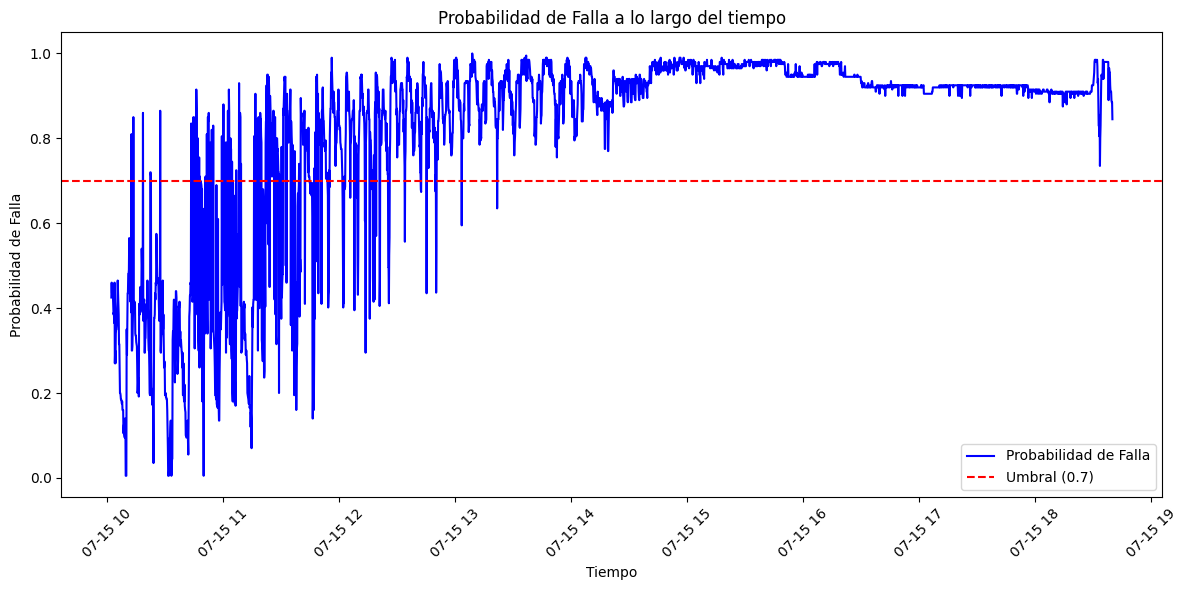

('2020-07-15 014:30:0', '2020-07-15 19:00:00')

In [ ]:
import matplotlib.pyplot as plt

# Graficar la probabilidad de falla a lo largo del tiempo
plt.figure(figsize=(12, 6))

# Graficamos la probabilidad de falla
plt.plot(predicciones_falla4['inicio_ventana'], predicciones_falla4['probabilidad_falla'], label='Probabilidad de Falla', color='b')

# A√±adir una l√≠nea de umbral de 0.7
plt.axhline(y=0.7, color='r', linestyle='--', label='Umbral (0.7)')

# Mejorar la visualizaci√≥n
plt.title('Probabilidad de Falla a lo largo del tiempo')
plt.xlabel('Tiempo')
plt.ylabel('Probabilidad de Falla')
plt.xticks(rotation=45)
plt.legend()

# Mostrar el gr√°fico
plt.tight_layout()
plt.show()

("2020-07-15 014:30:0", "2020-07-15 19:00:00")

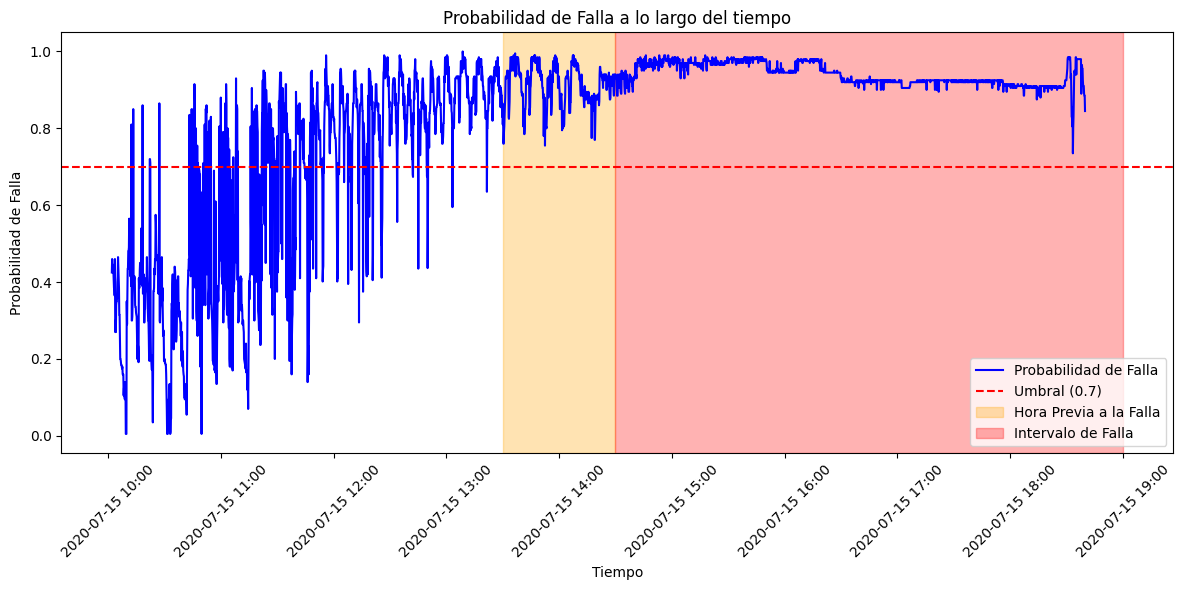

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Graficar la probabilidad de falla a lo largo del tiempo
plt.figure(figsize=(12, 6))

# Graficamos la probabilidad de falla
plt.plot(predicciones_falla4['inicio_ventana'], predicciones_falla4['probabilidad_falla'], label='Probabilidad de Falla', color='b')

# A√±adir una l√≠nea de umbral de 0.7
plt.axhline(y=0.7, color='r', linestyle='--', label='Umbral (0.7)')

# A√±adir los intervalos de tiempo (previo y falla) con colores
# Definir los intervalos de tiempo para falla y previo (convertir las fechas a datetime)
falla_inicio = pd.to_datetime("2020-07-15 14:30:00")
falla_fin = pd.to_datetime("2020-07-15 19:00:00")
previo_inicio = falla_inicio - pd.Timedelta(hours=1)
previo_fin = falla_inicio

# Resaltar el intervalo previo a la falla en naranja
plt.axvspan(previo_inicio, previo_fin, color='orange', alpha=0.3, label='Hora Previa a la Falla')

# Resaltar el intervalo de la falla en rojo
plt.axvspan(falla_inicio, falla_fin, color='red', alpha=0.3, label='Intervalo de Falla')

# Mejorar la visualizaci√≥n
plt.title('Probabilidad de Falla a lo largo del tiempo')
plt.xlabel('Tiempo')
plt.ylabel('Probabilidad de Falla')
plt.xticks(rotation=45)
plt.legend()

# Asegurarse de que el formato de las fechas sea adecuado en el eje x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

# Ajustar el dise√±o para que no se corten los elementos
plt.tight_layout()

# Mostrar el gr√°fico
plt.show()


In [ ]:
def predecir_en_ventanas(df, modelo_rf_optimo, ventana_tama√±o_minutos=20, horizonte_falla_minutos=60):
    """
    Aplica un modelo de Random Forest a datos en ventanas deslizantes.
    Para cada ventana de 20 minutos, predice si habr√° una falla en la siguiente hora.

    Par√°metros:
    - df: DataFrame con los datos hist√≥ricos, con una columna 'timestamp' y otras variables de entrada.
    - modelo_rf_optimo: el modelo Random Forest entrenado.
    - ventana_tama√±o_minutos: tama√±o de la ventana deslizante (en minutos).
    - horizonte_falla_minutos: horizonte de la predicci√≥n (en minutos) para detectar la falla.

    Retorna:
    - DataFrame con las predicciones de cada ventana.
    """

    # Asegurarse de que la columna 'timestamp' est√© en formato datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Lista para guardar las predicciones
    predicciones = []

    # Convertir el tama√±o de la ventana a timedelta
    ventana_tama√±o = pd.Timedelta(minutes=ventana_tama√±o_minutos)
    horizonte_falla = pd.Timedelta(minutes=horizonte_falla_minutos)

    # Deslizar la ventana por todo el DataFrame basado en la columna 'timestamp'
    for i in range(len(df) - 1):  # Recorremos por las filas
        inicio = df['timestamp'].iloc[i]  # Inicio de la ventana (timestamp de la fila actual)
        fin = inicio + ventana_tama√±o  # Fin de la ventana: sumar un 'Timedelta' a 'inicio'

        # Si el fin de la ventana excede el √∫ltimo timestamp disponible, terminamos el bucle
        if fin > df['timestamp'].iloc[-1]:  # Si la ventana excede los datos disponibles, salimos del bucle
            break

        # Extraer la ventana de 20 minutos (de 'inicio' a 'fin')
        ventana = df[(df['timestamp'] >= inicio) & (df['timestamp'] < fin)]

        # Variables de entrada (X) son las columnas de sensores, y el target (y) es 'estado'
        X_ventana = ventana[variables_seleccionadas]  # Aseg√∫rate de tener las variables definidas

        # Predecir la probabilidad de falla en la siguiente hora (horizonte de 60 minutos)
        y_prob = modelo_rf_optimo.predict_proba(X_ventana)

        # Calcular la hora de la falla estimada sumando el horizonte de la predicci√≥n al inicio de la ventana
        hora_falla = inicio + horizonte_falla

        # Almacenar la predicci√≥n para la ventana actual
        predicciones.append({
            'inicio_ventana': ventana['timestamp'].iloc[0],  # Primer timestamp de la ventana
            'probabilidad_falla': y_prob[-1][1],  # Probabilidad de que sea 'falla'
            'falla_prevista': 'falla' if y_prob[-1][1] > 0.7 else 'no falla',
            'hora_falla_predicha': hora_falla  # Hora estimada de la falla (en el futuro)
        })

    # Crear un DataFrame con las predicciones
    predicciones_df = pd.DataFrame(predicciones)

    return predicciones_df
df_falla4=pd.concat([datospoc4_pre, datospoc4_falla])

# Usar la funci√≥n para hacer predicciones para la falla 4
predicciones_falla4 = predecir_en_ventanas(datospoc4_pre, modelo_rf_optimo)

# Mostrar las primeras predicciones
print(predicciones_falla4.head())

       inicio_ventana  probabilidad_falla falla_prevista hora_falla_predicha
0 2020-07-15 10:02:03               0.425       no falla 2020-07-15 11:02:03
1 2020-07-15 10:02:13               0.460       no falla 2020-07-15 11:02:13
2 2020-07-15 10:02:23               0.435       no falla 2020-07-15 11:02:23
3 2020-07-15 10:02:32               0.435       no falla 2020-07-15 11:02:32
4 2020-07-15 10:02:42               0.445       no falla 2020-07-15 11:02:42


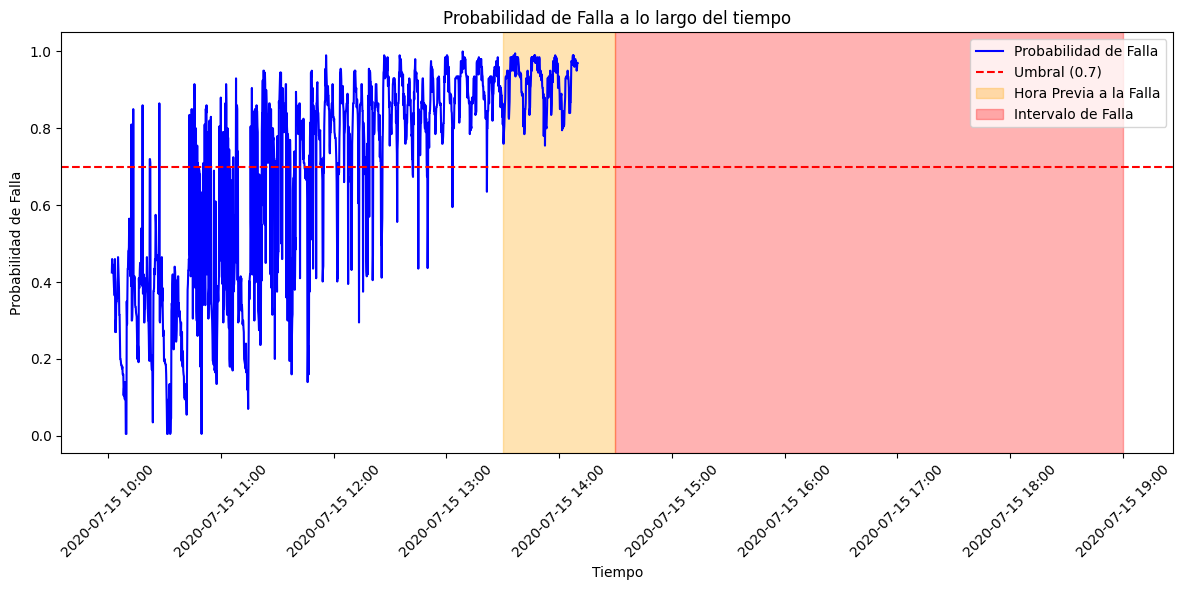

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Graficar la probabilidad de falla a lo largo del tiempo
plt.figure(figsize=(12, 6))

# Graficamos la probabilidad de falla
plt.plot(predicciones_falla4['inicio_ventana'], predicciones_falla4['probabilidad_falla'], label='Probabilidad de Falla', color='b')

# A√±adir una l√≠nea de umbral de 0.7
plt.axhline(y=0.7, color='r', linestyle='--', label='Umbral (0.7)')

# A√±adir los intervalos de tiempo (previo y falla) con colores
# Definir los intervalos de tiempo para falla y previo (convertir las fechas a datetime)
falla_inicio = pd.to_datetime("2020-07-15 14:30:00")
falla_fin = pd.to_datetime("2020-07-15 19:00:00")
previo_inicio = falla_inicio - pd.Timedelta(hours=1)
previo_fin = falla_inicio

# Resaltar el intervalo previo a la falla en naranja
plt.axvspan(previo_inicio, previo_fin, color='orange', alpha=0.3, label='Hora Previa a la Falla')

# Resaltar el intervalo de la falla en rojo
plt.axvspan(falla_inicio, falla_fin, color='red', alpha=0.3, label='Intervalo de Falla')

# Mejorar la visualizaci√≥n
plt.title('Probabilidad de Falla a lo largo del tiempo')
plt.xlabel('Tiempo')
plt.ylabel('Probabilidad de Falla')
plt.xticks(rotation=45)
plt.legend()

# Asegurarse de que el formato de las fechas sea adecuado en el eje x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

# Ajustar el dise√±o para que no se corten los elementos
plt.tight_layout()

# Mostrar el gr√°fico
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

def comparar_predicciones_con_realidad(predicciones_df, df_real, horizonte_falla_minutos=60):
    """
    Compara las predicciones de fallo con las etiquetas reales.

    Par√°metros:
    - predicciones_df: DataFrame con las predicciones del modelo (contiene 'inicio_ventana', 'probabilidad_falla', 'falla_prevista', etc.).
    - df_real: DataFrame con las etiquetas reales de fallo (debe tener la columna 'timestamp' y 'estado').
    - horizonte_falla_minutos: Horizonte de la predicci√≥n, que define hasta cu√°ndo se considera la falla real.

    Retorna:
    - classification_report: Reporte con m√©tricas de precisi√≥n, recall y f1-score.
    - confusion_matrix: Matriz de confusi√≥n para visualizar la performance del modelo.
    """

    # Asegurarse de que las columnas 'timestamp' en ambos DataFrames est√©n en formato datetime
    df_real['timestamp'] = pd.to_datetime(df_real['timestamp'])
    predicciones_df['inicio_ventana'] = pd.to_datetime(predicciones_df['inicio_ventana'])

    # Crear una lista para almacenar las etiquetas reales (y) y las predicciones (y_pred)
    y_true = []
    y_pred = []

    for _, pred in predicciones_df.iterrows():
        # Obtener el tiempo de inicio de la ventana
        inicio_ventana = pred['inicio_ventana']

        # Establecer el rango de tiempo de la predicci√≥n (falla futura en el horizonte de 60 minutos)
        fin_futura = inicio_ventana + pd.Timedelta(minutes=horizonte_falla_minutos)

        # Obtener las etiquetas reales de esa ventana (el estado dentro de ese per√≠odo de tiempo)
        ventana_real = df_real[(df_real['timestamp'] >= inicio_ventana) & (df_real['timestamp'] <= fin_futura)]

        # Si encontramos que hay una falla en el rango de tiempo, marcamos como 1 (falla), sino 0 (no falla)
        estado_real = ventana_real['estado'].max()  # Si hay una falla en esa ventana, max() devolver√° 1

        # A√±adir la etiqueta real a la lista
        y_true.append(estado_real)

        # La predicci√≥n del modelo, si la probabilidad de falla es mayor a 0.5
        y_pred.append(1 if pred['probabilidad_falla'] > 0.5 else 0)

    # Generar el reporte de clasificaci√≥n
    report = classification_report(y_true, y_pred)
    print("Reporte de clasificaci√≥n:")
    print(report)

    # Generar la matriz de confusi√≥n
    cm = confusion_matrix(y_true, y_pred)
    print("\nMatriz de confusi√≥n:")
    print(cm)

    return report, cm

# Comparar las predicciones de la falla 4 con los datos reales
report, cm = comparar_predicciones_con_realidad(predicciones_falla4, df_falla4)


Reporte de clasificaci√≥n:
              precision    recall  f1-score   support

           0       1.00      0.36      0.53      1259
           1       0.23      1.00      0.38       242

    accuracy                           0.47      1501
   macro avg       0.62      0.68      0.45      1501
weighted avg       0.88      0.47      0.51      1501


Matriz de confusi√≥n:
[[456 803]
 [  0 242]]


# ARMADO DE MODELO PARA EL MVP / PRODUCTO FINAL
La idea es preparar el modelo de cara al ensamble del producto final. El objetivo va a ser dividir los datos en train y test, entrenar el modelo y evaluar m√©tricas del mismo.

Para dividir los datos en entrenamiento y prueba vamos a hacer un split temporal para evitar data leakage. Vamos a utilizar la 4ta falla para hacer las pruebas del model.

Estos modelos dieron TODOS MAL -- NO VAN A A LA ENTREGA FINAL

In [ ]:
import numpy as np

# Cu√°ntas filas adelante equivale a 30 min(si cada fila = 10 segundos)
pasos = int((30 * 60) / 10)  # 180 pasos

# Crear una columna 'target' por posici√≥n
def crear_target_por_indice(df, pasos):
    target = []

    for i in range(len(df)):
        if i + pasos >= len(df):
            target.append(np.nan)
        else:
            target.append(df.iloc[i + pasos]["estado"])

    return target

# Aplicar
df["target"] = crear_target_por_indice(df, pasos)

print(df["target"].value_counts(dropna=False))



target
0.0    1486814
1.0      29954
NaN        180
Name: count, dtype: int64


In [ ]:
def split_temporal_con_falla(df, timestamp_col, ultima_falla_str, proporcion_train=0.7):
    """
    Divide un DataFrame temporal en entrenamiento y test asegurando que la √∫ltima falla quede en test.

    Par√°metros:
        df (pd.DataFrame): el DataFrame original.
        timestamp_col (str): nombre de la columna con timestamps.
        ultima_falla_str (str): timestamp de la √∫ltima falla (ej. '2020-07-15 14:30:00').
        proporcion_train (float): proporci√≥n del conjunto de entrenamiento (por defecto 0.7).

    Retorna:
        df_train, df_test (pd.DataFrame, pd.DataFrame)
    """
    df = df.sort_values(timestamp_col)
    ultima_falla = pd.to_datetime(ultima_falla_str)

    # Timestamp correspondiente al corte del % de entrenamiento
    corte_idx = int(len(df) * proporcion_train)
    timestamp_corte = df.iloc[corte_idx][timestamp_col]

    # Si la √∫ltima falla no cae en test, ajustar corte para que quede incluida
    if ultima_falla <= timestamp_corte:
        timestamp_corte = df[df[timestamp_col] < ultima_falla].iloc[-1][timestamp_col]

    df_train = df[df[timestamp_col] <= timestamp_corte]
    df_test = df[df[timestamp_col] > timestamp_corte]

    return df_train, df_test

df_train, df_test = split_temporal_con_falla(df, "timestamp", "2020-07-15 14:30:00")


print(len(df_train))
print(len(df_test))

print("Valores de target en df_train", df_train["target"].value_counts(dropna=False))
print("Valores de target en df_test", df_test["target"].value_counts(dropna=False))
# Eliminamos los NaN que son 360, ser√≠a una hora del dataset. No es estad√≠sticamente significativo, representa menos del 1%.
df_test = df_test.dropna(subset=["target"])



1061864
455084
Valores de target en df_train target
0.0    1033532
1.0      28332
Name: count, dtype: int64
Valores de target en df_test target
0.0    453282
1.0      1622
NaN       180
Name: count, dtype: int64


Ahora se va a entrenar el modelo. Como en los datos de train solamente tenemos 2% de la clase 1, quiz√°s tengamos que balancear esas clases. Primero vamos a entrenar el modelo con esa distribuci√≥n. Luego vamos a analizar las m√©tricas propias del modelo. En caso de que alcancemos

Reporte de clasificaci√≥n:

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    453282
         1.0       0.00      0.00      0.00      1622

    accuracy                           1.00    454904
   macro avg       0.50      0.50      0.50    454904
weighted avg       0.99      1.00      0.99    454904



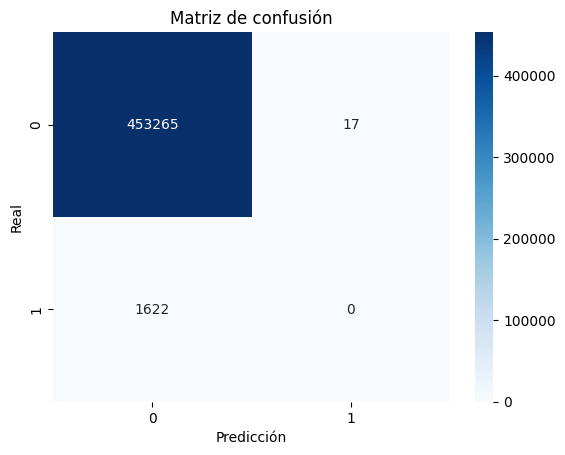

In [ ]:
# Variables seleccionadas de la POC
variables_seleccionadas = ["DV_pressure", "Oil_temperature", "Reservoirs", "TP3", "TP2", "H1"]

# Entradas y salidas
X_train = df_train[variables_seleccionadas]
y_train = df_train["target"]

X_test = df_test[variables_seleccionadas]
y_test = df_test["target"]

# Entrenamiento del modelo
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_rf.fit(X_train, y_train)

# Predicciones
y_pred = modelo_rf.predict(X_test)

# Reporte de m√©tricas
print("Reporte de clasificaci√≥n:\n")
print(classification_report(y_test, y_pred))

# Matriz de confusi√≥n
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicci√≥n")
plt.ylabel("Real")
plt.title("Matriz de confusi√≥n")
plt.show()


Random Forest con class_weight='balanced'

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    453102
         1.0       0.00      0.00      0.00      1622

    accuracy                           1.00    454724
   macro avg       0.50      0.50      0.50    454724
weighted avg       0.99      1.00      0.99    454724



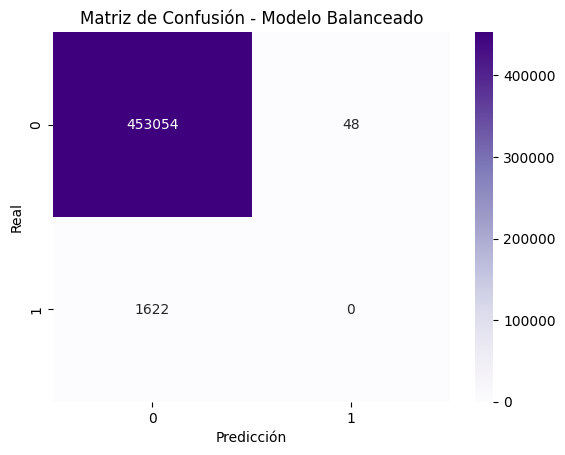

In [ ]:
modelo_rf_balanceado = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight="balanced"  # <- clave para que le preste atenci√≥n a clase 1
)
modelo_rf_balanceado.fit(X_train, y_train)

y_pred_bal = modelo_rf_balanceado.predict(X_test)

# M√©tricas
print("Random Forest con class_weight='balanced'\n")
print(classification_report(y_test, y_pred_bal))

# Matriz de confusi√≥n
cm = confusion_matrix(y_test, y_pred_bal)
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicci√≥n")
plt.ylabel("Real")
plt.title("Matriz de Confusi√≥n - Modelo Balanceado")
plt.show()


Como se observa en ambas matrices de confusi√≥n, el modelo es incapaz de identificar correctamente los casos de falla (clase 1). Esto se debe al fuerte desbalance en la distribuci√≥n de clases, donde los eventos de falla son significativamente menos frecuentes que los normales (clase 0). Esta diferencia provoca que el modelo tienda a predecir √∫nicamente la clase mayoritaria.

SUBSAMPLING

1.   Random undersampling
2.   Cluster centroids

Toma todas las muestras de la clase minoritaria (1)

Luego selecciona al azar la misma cantidad de muestras de la clase mayoritaria (0)
Balance√°s las clases de forma r√°pida y entendible.

F√°cil de implementar.

¬øCu√°ndo no conviene?
Si la clase mayoritaria tiene mucha variabilidad ‚Üí podr√≠as eliminar info √∫til.

2

¬øQu√© hace?
Aplica clustering (ej: K-Means) a la clase mayoritaria y reemplaza los datos por los centroides de esos clusters.

¬øPor qu√© sirve?
Reduce la clase mayoritaria sin perder su estructura general.

¬øEs explicable?
S√≠: ‚Äúusamos puntos representativos para mantener la diversidad sin usar todos los datos‚Äù.

In [ ]:
from sklearn.utils import resample

# Separar clases
df_majority = df_train[df_train["target"] == 0]
df_minority = df_train[df_train["target"] == 1]

# Submuestreo aleatorio de la clase mayoritaria
df_majority_downsampled = resample(
    df_majority,
    replace=False,
    n_samples=len(df_minority),
    random_state=42
)

# Concatenar y mezclar
df_train_random = pd.concat([df_majority_downsampled, df_minority]).sample(frac=1, random_state=42)
print("Valores de target en df_test", df_train_random["target"].value_counts(dropna=False))


Valores de target en df_test target
1.0    28332
0.0    28332
Name: count, dtype: int64


Trabajamos el modelo over sampleado, ya que el subsampleo no sirvi√≥ antes

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# Variables predictoras
variables = ["DV_pressure", "Oil_temperature", "Reservoirs", "TP3", "TP2", "H1"]
X_train = df_train[variables]
y_train = df_train["target"]

# Aplicar Random Oversampling
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

# Reconstruir DataFrame balanceado
df_train_oversampled = pd.DataFrame(X_ros, columns=variables)
df_train_oversampled["target"] = y_ros

# Verificar nuevo balance
print(df_train_oversampled["target"].value_counts())


target
0.0    1033532
1.0    1033532
Name: count, dtype: int64


Random Forest con TODAS las variables num√©ricas (ajuste intensificado):

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    453282
         1.0       0.00      0.00      0.00      1622

    accuracy                           1.00    454904
   macro avg       0.50      0.50      0.50    454904
weighted avg       0.99      1.00      0.99    454904



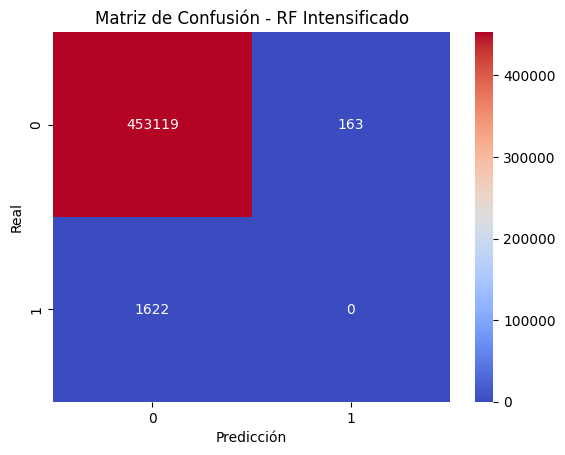

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# üëâ Ampliar el muestreo del dataset oversampleado
df_sampled = df_train_oversampled.sample(n=200_000, random_state=42)

# üëâ Todas las variables num√©ricas excepto estado y target
variables_todas = df_sampled.select_dtypes(include='number').drop(columns=["estado", "target"], errors='ignore').columns.tolist()

X_train_full = df_sampled[variables_todas]
y_train_full = df_sampled["target"]

X_test_full = df_test[variables_todas]
y_test_full = df_test["target"]

# üëâ Modelo m√°s potente pero a√∫n razonable
modelo_rf_full = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_leaf=3,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)

# Entrenar
modelo_rf_full.fit(X_train_full, y_train_full)

# Predecir
y_pred_full = modelo_rf_full.predict(X_test_full)

# Evaluaci√≥n
print("Random Forest con TODAS las variables num√©ricas (ajuste intensificado):\n")
print(classification_report(y_test_full, y_pred_full))

cm = confusion_matrix(y_test_full, y_pred_full)
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicci√≥n")
plt.ylabel("Real")
plt.title("Matriz de Confusi√≥n - RF Intensificado")
plt.show()




# INTENTAMOS MODELAR CON MENOS TIEMPO A VER SI MEJORAN LAS METRICAS


In [ ]:
import numpy as np

# Cu√°ntas filas adelante equivale a 10 minutos (cada fila = 10 segundos)
pasos = int((10 * 60) / 10)  # 60 pasos

# Crear una columna 'target' por posici√≥n
def crear_target_por_indice(df, pasos):
    target = []
    for i in range(len(df)):
        if i + pasos >= len(df):
            target.append(np.nan)
        else:
            target.append(df.iloc[i + pasos]["estado"])
    return target

# Aplicar y guardar en un nuevo DataFrame
df["target"] = crear_target_por_indice(df, pasos)
df_10min = df.copy()

# Verificar distribuci√≥n de valores
print(df_10min["target"].value_counts(dropna=False))


KeyboardInterrupt: 

In [ ]:
# Subsampling adaptado a df_10min
def subsampling(df, intervalo_falla):
    inicio, fin = pd.to_datetime(intervalo_falla[0]), pd.to_datetime(intervalo_falla[1])
    datos_falla = df[(df["timestamp"] >= inicio) & (df["timestamp"] <= fin)].copy()
    num_falla = len(datos_falla)
    idx_inicio = df[df["timestamp"] >= inicio].index[0]
    idx_pre_falla = idx_inicio - num_falla
    datos_pre_falla = df.iloc[idx_pre_falla:idx_inicio].copy()
    return datos_pre_falla, datos_falla

# Definir fallas
falla1 = ("2020-04-18 00:00:00", "2020-04-18 23:59:00")
falla2 = ("2020-05-29 23:30:00", "2020-05-30 06:00:00")
falla3 = ("2020-06-05 10:00:00", "2020-06-07 14:30:00")
falla4 = ("2020-07-15 14:30:00", "2020-07-15 19:00:00")

# Submuestras
pre1, f1 = subsampling(df_10min, falla1)
pre2, f2 = subsampling(df_10min, falla2)
pre3, f3 = subsampling(df_10min, falla3)
pre4, f4 = subsampling(df_10min, falla4)


In [ ]:
# Dataset de entrenamiento (falla 1‚Äì3)
df_train = pd.concat([pre1, f1, pre2, f2, pre3, f3]).dropna(subset=["target"]).copy()
df_train["target"] = df_train["target"].astype(int)

# Dataset de testeo (falla 4)
df_test = pd.concat([pre4, f4]).dropna(subset=["target"]).copy()
df_test["target"] = df_test["target"].astype(int)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score
from scipy.stats import randint

# Features y target
features = ["DV_pressure", "Oil_temperature", "Reservoirs", "TP3", "TP2", "H1"]
X_all = df_all_fallas[features]
y_all = df_all_fallas["target"]

# Definici√≥n del modelo base
rf_base = RandomForestClassifier(random_state=42)

# Hiperpar√°metros a probar (rango razonable)
param_dist = {
    "n_estimators": randint(100, 300),
    "max_depth": [5, 10, 15, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"],
    "bootstrap": [True, False]
}

# Usamos F1 para clase 1 como m√©trica (fallas)
scorer = make_scorer(f1_score, pos_label=1)

# B√∫squeda aleatoria
random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=30,
    scoring=scorer,
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Entrenar b√∫squeda
random_search.fit(X_all, y_all)

# Mejor modelo
best_rf = random_search.best_estimator_

# Evaluaci√≥n sobre los mismos datos (como hac√≠as antes)
y_pred_all = best_rf.predict(X_all)

print("üìä Evaluaci√≥n del Random Forest optimizado:")
print(classification_report(y_all, y_pred_all, digits=4))
print("üß© Matriz de confusi√≥n:")
print(confusion_matrix(y_all, y_pred_all))

# Mostrar los mejores par√°metros
print("üß† Mejores par√°metros encontrados:")
print(random_search.best_params_)




NameError: name 'df_all_fallas' is not defined

aplicamos al dataset entero

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# 1. Preparamos los datos reales (sin NaNs en target)
df_real = df_10min.dropna(subset=["target"]).copy()
df_real["target"] = df_real["target"].astype(int)

# 2. Features y target
X_real = df_real[features]
y_real = df_real["target"]

# 3. Predicci√≥n con el modelo optimizado
y_pred_real = best_rf.predict(X_real)

# 4. Evaluaci√≥n
print("üìä Evaluaci√≥n del Random Forest optimizado sobre df_10min completo:")
print(classification_report(y_real, y_pred_real, digits=4))

print("üß© Matriz de confusi√≥n:")
print(confusion_matrix(y_real, y_pred_real))


NameError: name 'best_rf' is not defined

In [ ]:
# 1. Filtrar solo las filas v√°lidas (donde target no es NaN)
df_real = df_10min.dropna(subset=["target"]).copy()
df_real["target"] = df_real["target"].astype(int)

# 2. Features y target
X_real = df_real[features]
y_real = df_real["target"]

# 3. Predicci√≥n con el modelo entrenado sobre todas las fallas
y_pred_real = modelo_full.predict(X_real)

# 4. Evaluaci√≥n
from sklearn.metrics import classification_report, confusion_matrix

print("üìä Evaluaci√≥n del modelo entrenado con las 4 fallas aplicado a df_10min completo:")
print(classification_report(y_real, y_pred_real, digits=4))
print("üß© Matriz de confusi√≥n:")
print(confusion_matrix(y_real, y_pred_real))


üìä Evaluaci√≥n del modelo entrenado con las 4 fallas aplicado a df_10min completo:
              precision    recall  f1-score   support

           0     0.9999    0.9855    0.9926   1486934
           1     0.5797    0.9950    0.7326     29954

    accuracy                         0.9857   1516888
   macro avg     0.7898    0.9902    0.8626   1516888
weighted avg     0.9916    0.9857    0.9875   1516888

üß© Matriz de confusi√≥n:
[[1465327   21607]
 [    151   29803]]


TODAV√çA TENEMOS MUCHOS FALSOS POSITIVOS... APLICAMOS UN CAMBIO EN THRESHOLD



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# 1. Preparar los datos reales
df_real = df_10min.dropna(subset=["target"]).copy()
df_real["target"] = df_real["target"].astype(int)

X_real = df_real[features]
y_real = df_real["target"]

# 2. Obtener probabilidades
probs = modelo_conservador.predict_proba(X_real)[:, 1]

# 3. Aplicar threshold manual de 0.7
threshold = 0.7
y_pred_custom = (probs >= threshold).astype(int)

# 4. Evaluaci√≥n
print(f"üìä Evaluaci√≥n con threshold personalizado = {threshold}:")
print(classification_report(y_real, y_pred_custom, digits=4))
print("üß© Matriz de confusi√≥n:")
print(confusion_matrix(y_real, y_pred_custom))


üìä Evaluaci√≥n con threshold personalizado = 0.7:
              precision    recall  f1-score   support

           0     0.9999    0.9858    0.9928   1486934
           1     0.5854    0.9931    0.7366     29954

    accuracy                         0.9860   1516888
   macro avg     0.7926    0.9894    0.8647   1516888
weighted avg     0.9917    0.9860    0.9877   1516888

üß© Matriz de confusi√≥n:
[[1465864   21070]
 [    208   29746]]


VAMOS A TRABAJAR VARIABLES CONTINUAS PARA UTILIZAR PROMEDIOS MOVILES, VARIANZA MOVIL O LA DESVIACI√ìN DEL PROMEDIO MOVIL, PARA VER SI SE PUEDE CAPTAR MEJOR EL COMPORTAMIENTO DE LAS VARIABLES

In [ ]:
df_10min["DV_pressure_ma6"] = df_10min["DV_pressure"].rolling(window=6, min_periods=1).mean()
df_10min["DV_pressure_diff"] = df_10min["DV_pressure"] - df_10min["DV_pressure_ma6"]
df_10min["DV_pressure_var6"] = df_10min["DV_pressure"].rolling(window=6, min_periods=1).var()


In [ ]:
# Crear features derivadas de DV_pressure en df_10min
df_10min = df_10min.copy()

df_10min["DV_pressure_ma6"] = df_10min["DV_pressure"].rolling(window=6, min_periods=1).mean()
df_10min["DV_pressure_diff"] = df_10min["DV_pressure"] - df_10min["DV_pressure_ma6"]
df_10min["DV_pressure_var6"] = df_10min["DV_pressure"].rolling(window=6, min_periods=1).var()

# Regenerar los bloques para train y test con las nuevas columnnas
pre1, f1 = subsampling(df_10min, falla1)
pre2, f2 = subsampling(df_10min, falla2)
pre3, f3 = subsampling(df_10min, falla3)
pre4, f4 = subsampling(df_10min, falla4)

# Armar dataset completo
df_all_fallas = pd.concat([pre1, f1, pre2, f2, pre3, f3, pre4, f4])
df_all_fallas = df_all_fallas.dropna(subset=["target", "DV_pressure_diff"]).copy()
df_all_fallas["target"] = df_all_fallas["target"].astype(int)

# Usamos DV_pressure_diff en lugar de DV_pressure
features_mod = ["DV_pressure_diff", "Oil_temperature", "Reservoirs", "TP3", "TP2", "H1"]

X_train = df_all_fallas[features_mod]
y_train = df_all_fallas["target"]

# Entrenar modelo conservador
from sklearn.ensemble import RandomForestClassifier

modelo_dv_diff = RandomForestClassifier(
    random_state=42,
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=4,
    min_samples_split=5,
    bootstrap=True,
    max_features="sqrt"
)
modelo_dv_diff.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200, random_state=42)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Preparar datos reales
df_real = df_10min.dropna(subset=["target", "DV_pressure_diff"]).copy()
df_real["target"] = df_real["target"].astype(int)

X_real = df_real[features_mod]
y_real = df_real["target"]

# Predicci√≥n
y_pred = modelo_dv_diff.predict(X_real)

# Evaluaci√≥n
print("üìä Modelo con DV_pressure_diff aplicado a df_10min completo:")
print(classification_report(y_real, y_pred, digits=4))
print("üß© Matriz de confusi√≥n:")
print(confusion_matrix(y_real, y_pred))


üìä Modelo con DV_pressure_diff aplicado a df_10min completo:
              precision    recall  f1-score   support

           0     0.9999    0.9835    0.9916   1486934
           1     0.5479    0.9937    0.7063     29954

    accuracy                         0.9837   1516888
   macro avg     0.7739    0.9886    0.8490   1516888
weighted avg     0.9909    0.9837    0.9860   1516888

üß© Matriz de confusi√≥n:
[[1462371   24563]
 [    188   29766]]


In [ ]:
# Variables continuas a analizar
variables_continuas = ["DV_pressure", "TP2", "TP3", "H1", "Reservoirs", "Oil_temperature"]

# Unir bloques
df_pre_falla = pd.concat([pre1, pre2, pre3, pre4])
df_durante_falla = pd.concat([f1, f2, f3, f4])

# Calcular varianza por grupo
print("üìä Varianza por variable (Pre-falla vs Falla):\n")
for var in variables_continuas:
    var_pre = df_pre_falla[var].var()
    var_falla = df_durante_falla[var].var()
    print(f"{var:15s} ‚Üí Pre-falla: {var_pre:.4f} | Falla: {var_falla:.4f} | Œî: {var_falla - var_pre:.4f}")



üìä Varianza por variable (Pre-falla vs Falla):

DV_pressure     ‚Üí Pre-falla: 0.0822 | Falla: 0.2699 | Œî: 0.1877
TP2             ‚Üí Pre-falla: 9.4095 | Falla: 0.9651 | Œî: -8.4444
TP3             ‚Üí Pre-falla: 0.3657 | Falla: 0.2454 | Œî: -0.1202
H1              ‚Üí Pre-falla: 9.0658 | Falla: 0.3936 | Œî: -8.6722
Reservoirs      ‚Üí Pre-falla: 0.3647 | Falla: 0.2454 | Œî: -0.1194
Oil_temperature ‚Üí Pre-falla: 60.1188 | Falla: 8.5963 | Œî: -51.5225


In [ ]:
# Aseguramos que DV_pressure_var6 est√© calculado en df_10min
df_10min["DV_pressure_ma6"] = df_10min["DV_pressure"].rolling(window=6, min_periods=1).mean()
df_10min["DV_pressure_var6"] = df_10min["DV_pressure"].rolling(window=6, min_periods=1).var()

# Regenerar los bloques (por si los anteriores no ten√≠an esta columna)
pre1, f1 = subsampling(df_10min, falla1)
pre2, f2 = subsampling(df_10min, falla2)
pre3, f3 = subsampling(df_10min, falla3)
pre4, f4 = subsampling(df_10min, falla4)

# Unir todo
df_all_fallas = pd.concat([pre1, f1, pre2, f2, pre3, f3, pre4, f4])
df_all_fallas = df_all_fallas.dropna(subset=["target", "DV_pressure_var6"]).copy()
df_all_fallas["target"] = df_all_fallas["target"].astype(int)

# Usamos DV_pressure y su varianza
features_mod = ["DV_pressure", "DV_pressure_var6", "Oil_temperature", "Reservoirs", "TP3", "TP2", "H1"]

X_train = df_all_fallas[features_mod]
y_train = df_all_fallas["target"]

# Entrenar modelo conservador
from sklearn.ensemble import RandomForestClassifier

modelo_varianza = RandomForestClassifier(
    random_state=42,
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=4,
    min_samples_split=5,
    bootstrap=True,
    max_features="sqrt"
)
modelo_varianza.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200, random_state=42)

In [ ]:
df_real = df_10min.dropna(subset=["target", "DV_pressure_var6"]).copy()
df_real["target"] = df_real["target"].astype(int)

X_real = df_real[features_mod]
y_real = df_real["target"]

# Predicci√≥n
y_pred = modelo_varianza.predict(X_real)

# Evaluaci√≥n
print("üìä Modelo con DV_pressure + DV_pressure_var6 aplicado a df_10min completo:")
print(classification_report(y_real, y_pred, digits=4))
print("üß© Matriz de confusi√≥n:")
print(confusion_matrix(y_real, y_pred))


üìä Modelo con DV_pressure + DV_pressure_var6 aplicado a df_10min completo:
              precision    recall  f1-score   support

           0     0.9999    0.9854    0.9926   1486933
           1     0.5779    0.9939    0.7309     29954

    accuracy                         0.9855   1516887
   macro avg     0.7889    0.9896    0.8617   1516887
weighted avg     0.9915    0.9855    0.9874   1516887

üß© Matriz de confusi√≥n:
[[1465189   21744]
 [    183   29771]]


Vemos la importancia de las variables de este √∫ltimo modeo que es el que mejor precisi√≥n tuvo en la clase de FALLA.

In [ ]:
importances = modelo_varianza.feature_importances_
for feat, imp in sorted(zip(features_mod, importances), key=lambda x: -x[1]):
    print(f"{feat}: {imp:.4f}")


DV_pressure: 0.3551
DV_pressure_var6: 0.2186
Oil_temperature: 0.1897
TP2: 0.1308
H1: 0.0448
TP3: 0.0343
Reservoirs: 0.0266


Eliminamos h1, tp3 y reservoirs para eliminar ruido y dejar las variables con m√°s capacidad predictiva.

In [ ]:
features_top = ["DV_pressure", "DV_pressure_var6", "Oil_temperature", "TP2"]


In [ ]:
# Aseguramos que DV_pressure_var6 est√© calculado en df_10min
df_10min["DV_pressure_ma6"] = df_10min["DV_pressure"].rolling(window=6, min_periods=1).mean()
df_10min["DV_pressure_var6"] = df_10min["DV_pressure"].rolling(window=6, min_periods=1).var()

# Regenerar los bloques (por si los anteriores no ten√≠an esta columna)
pre1, f1 = subsampling(df_10min, falla1)
pre2, f2 = subsampling(df_10min, falla2)
pre3, f3 = subsampling(df_10min, falla3)
pre4, f4 = subsampling(df_10min, falla4)

# Unir todo
df_all_fallas = pd.concat([pre1, f1, pre2, f2, pre3, f3, pre4, f4])
df_all_fallas = df_all_fallas.dropna(subset=["target", "DV_pressure_var6"]).copy()
df_all_fallas["target"] = df_all_fallas["target"].astype(int)

# Predecimos con las feature top

X_train = df_all_fallas[features_top]
y_train = df_all_fallas["target"]

# Entrenar modelo conservador
from sklearn.ensemble import RandomForestClassifier

modelo_varianza = RandomForestClassifier(
    random_state=42,
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=4,
    min_samples_split=5,
    bootstrap=True,
    max_features="sqrt"
)
modelo_varianza.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200, random_state=42)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Aseguramos que target y las columnas necesarias est√©n presentes
df_real = df_10min.dropna(subset=["target", "DV_pressure_var6"]).copy()
df_real["target"] = df_real["target"].astype(int)

# Usar las mismas features que en el entrenamiento
X_real = df_real[features_top]
y_real = df_real["target"]

# Predicci√≥n
y_pred = modelo_varianza.predict(X_real)

# Evaluaci√≥n
print("üìä Modelo con solo las variables m√°s importantes:")
print(classification_report(y_real, y_pred, digits=4))
print("üß© Matriz de confusi√≥n:")
print(confusion_matrix(y_real, y_pred))


üìä Modelo con solo las variables m√°s importantes:
              precision    recall  f1-score   support

           0     0.9999    0.9916    0.9957   1486933
           1     0.7054    0.9940    0.8252     29954

    accuracy                         0.9917   1516887
   macro avg     0.8526    0.9928    0.9104   1516887
weighted avg     0.9941    0.9917    0.9924   1516887

üß© Matriz de confusi√≥n:
[[1474497   12436]
 [    181   29773]]


Ahora le ponemos un threshold de 0,6

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Preparar datos
df_real = df_10min.dropna(subset=["target", "DV_pressure_var6"]).copy()
df_real["target"] = df_real["target"].astype(int)

X_real = df_real[features_top]
y_real = df_real["target"]

# Probabilidades
probs = modelo_varianza.predict_proba(X_real)[:, 1]

# Aplicar threshold personalizado
threshold = 0.9
y_pred_custom = (probs >= threshold).astype(int)

# Evaluaci√≥n
print(f"üìä Evaluaci√≥n con threshold personalizado = {threshold}:")
print(classification_report(y_real, y_pred_custom, digits=4))
print("üß© Matriz de confusi√≥n:")
print(confusion_matrix(y_real, y_pred_custom))


üìä Evaluaci√≥n con threshold personalizado = 0.9:
              precision    recall  f1-score   support

           0     0.9998    0.9938    0.9968   1486933
           1     0.7622    0.9887    0.8608     29954

    accuracy                         0.9937   1516887
   macro avg     0.8810    0.9912    0.9288   1516887
weighted avg     0.9951    0.9937    0.9941   1516887

üß© Matriz de confusi√≥n:
[[1477692    9241]
 [    339   29615]]


LE QUITAMOS MAS COMPLEJIDAD

# Probamos con 30 minutos previos
El problema estaba en el modelo, no en el tiempo. Finalmente las m√©tricas son malas, por lo que con este dataset no se puede predecir con mucha antelaci√≥n, por los patrones propios de los datos.

In [ ]:
df_30min = df.copy()

# Cu√°ntas filas adelante equivale a 20 min (si cada fila = 10 segundos)


# Aplicar al DataFrame, como nueva columna


# Ver distribuci√≥n de valores
print(df_30min["target"].value_counts(dropna=False))



target
0.0    1486934
1.0      29954
NaN         60
Name: count, dtype: int64


In [ ]:
# Funci√≥n de subsampling adaptada a df_30min
def subsampling(df, intervalo_falla):
    inicio, fin = pd.to_datetime(intervalo_falla[0]), pd.to_datetime(intervalo_falla[1])
    datos_falla = df[(df["timestamp"] >= inicio) & (df["timestamp"] <= fin)].copy()
    num_falla = len(datos_falla)
    idx_inicio = df[df["timestamp"] >= inicio].index[0]
    idx_pre_falla = idx_inicio - num_falla
    datos_pre_falla = df.iloc[idx_pre_falla:idx_inicio].copy()
    return datos_pre_falla, datos_falla

# Definir intervalos de falla
falla1 = ("2020-04-18 00:00:00", "2020-04-18 23:59:00")
falla2 = ("2020-05-29 23:30:00", "2020-05-30 06:00:00")
falla3 = ("2020-06-05 10:00:00", "2020-06-07 14:30:00")
falla4 = ("2020-07-15 14:30:00", "2020-07-15 19:00:00")

# Aplicar a df_30min
pre1_30, f1_30 = subsampling(df_30min, falla1)
pre2_30, f2_30 = subsampling(df_30min, falla2)
pre3_30, f3_30 = subsampling(df_30min, falla3)
pre4_30, f4_30 = subsampling(df_30min, falla4)


Creamos de nuevo la variable derivada de DV PRESSURE y la agregamos al dataset. La ventana para calcualr el promedio movil de la variable cambia, ya que ahora tomamos 30 minutos para predecir (3 veces mas), entonces utilizamos la ventana de 3 minutos en lugar de 1 minuto. Usa 6 pasos previos

In [ ]:
# Crear df_30min desde df original (resampleado cada 30 minutos)
df_30min = df.set_index("timestamp").resample("30T").mean().reset_index()

# Calcular media m√≥vil y varianza m√≥vil (ventana de 3 pasos de 30min = 1.5h)
df_30min["DV_pressure_ma6"] = df_30min["DV_pressure"].rolling(window=3, min_periods=1).mean()
df_30min["DV_pressure_var6"] = df_30min["DV_pressure"].rolling(window=3, min_periods=1).var()


/tmp/ipython-input-251-2371232656.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_30min = df.set_index("timestamp").resample("30T").mean().reset_index()


Reutilizamos sumsampling para formatear el dataset en los per√≠odos de falla y entrenamos bajo las features correspondientes.

In [ ]:
# Subsampling en df_30min
pre1_30, f1_30 = subsampling(df_30min, falla1)
pre2_30, f2_30 = subsampling(df_30min, falla2)
pre3_30, f3_30 = subsampling(df_30min, falla3)
pre4_30, f4_30 = subsampling(df_30min, falla4)

# Concatenar bloques y limpiar
df_all_fallas_30 = pd.concat([pre1_30, f1_30, pre2_30, f2_30, pre3_30, f3_30, pre4_30, f4_30])
df_all_fallas_30 = df_all_fallas_30.dropna(subset=["target", "DV_pressure_ma6"]).copy()
df_all_fallas_30["target"] = df_all_fallas_30["target"].astype(int)

# Features
features_top_30 = ["DV_pressure", "DV_pressure_ma6", "Oil_temperature", "TP2"]
X_train_30 = df_all_fallas_30[features_top_30]
y_train_30 = df_all_fallas_30["target"]

# Modelo Random Forest para datos a 30 minutos
from sklearn.ensemble import RandomForestClassifier

modelo_varianza_30min = RandomForestClassifier(
    random_state=42,
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=4,
    min_samples_split=5,
    bootstrap=True,
    max_features="sqrt"
)
modelo_varianza_30min.fit(X_train_30, y_train_30)


RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=200, random_state=42)

‚úÖ C√ìDIGO ‚Äî Evaluaci√≥n sobre df_30min completo con threshold = 0.6
python
Copiar
Editar


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Asegurar que los datos est√©n limpios
df_eval_30 = df_30min.dropna(subset=["target", "DV_pressure_ma6", "TP2"]).copy()
df_eval_30["target"] = df_eval_30["target"].astype(int)

# Features y target
X_real_30 = df_eval_30[features_top_30]
y_real_30 = df_eval_30["target"]

# Predecir probabilidades
probs_30 = modelo_varianza_30min.predict_proba(X_real_30)[:, 1]

# Aplicar threshold
threshold = 0.6
y_pred_30 = (probs_30 >= threshold).astype(int)

# Evaluar
print(f"üìä Evaluaci√≥n del modelo a 30 min (threshold = {threshold}):")
print(classification_report(y_real_30, y_pred_30, digits=4))
print("üß© Matriz de confusi√≥n:")
print(confusion_matrix(y_real_30, y_pred_30))


üìä Evaluaci√≥n del modelo a 30 min (threshold = 0.6):
              precision    recall  f1-score   support

           0     0.9998    0.9786    0.9890      8487
           1     0.4694    0.9877    0.6364       163

    accuracy                         0.9787      8650
   macro avg     0.7346    0.9831    0.8127      8650
weighted avg     0.9898    0.9787    0.9824      8650

üß© Matriz de confusi√≥n:
[[8305  182]
 [   2  161]]
